# 1. Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

/home/hcilab/anaconda3/envs/kybpark/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).

  from pandas.core.computation.check import NUMEXPR_INSTALLED

[nltk_data] Downloading package stopwords to /home/hcilab/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


# 2. Configurations

In [4]:
news_data = pd.read_csv('data/WELFake_Dataset.csv')

In [5]:
class_names = ['fake', 'real'] # 0: fake, 1: real

In [6]:
news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 72134 entries, 0 to 72133

Data columns (total 4 columns):

 #   Column      Non-Null Count  Dtype 

---  ------      --------------  ----- 

 0   Unnamed: 0  72134 non-null  int64 

 1   title       71576 non-null  object

 2   text        72095 non-null  object

 3   label       72134 non-null  int64 

dtypes: int64(2), object(2)

memory usage: 2.2+ MB


In [5]:
news_data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [6]:
news_data = news_data.fillna('')

In [7]:
news_data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [8]:
news_data.nunique()

Unnamed: 0    72134
title         62348
text          62719
label             2
dtype: int64

/home/hcilab/anaconda3/envs/kybpark/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  warnings.warn(


Text(0.5, 1.0, 'Target Count')

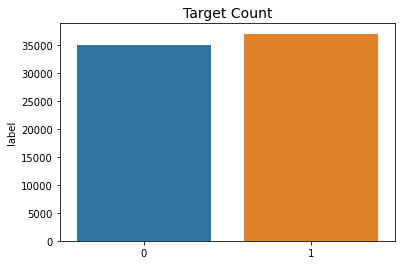

In [9]:
label_count = news_data.label.value_counts()
sns.barplot(label_count.index, label_count)
plt.title('Target Count', fontsize=14)

# 3. Building Dataset

### Stemming & Extracting text data using TF-IDF

In [10]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

Since there are too many text data, we extracted only important words using TF-IDF.

In [11]:
def refinement_tfidf(text): # TF-IDF
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) # setting the importance weights according to TF-IDF
    
    return refined_text

In [13]:
t0 = time.time()
news_data['refined_tfidf'] = news_data['text'].apply(refinement_tfidf)
print(time.time() - t0) # It takes about 45 minutes...

2658.292627096176


In [14]:
news_data.head()

,Unnamed: 0,title,text,label,refined_tfidf
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,said
1,1,,Did they post their votes for Hillary already?,1,alreadi hillari post vote
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,aka chang constitut creat demonstr eric exerci...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,jindal
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,design dub km mile missil rs sarmat satan weapon


In [15]:
labels = news_data['label'].values
texts = (news_data['title'] + ' ' + news_data['refined_tfidf']).values

### Tokenization

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [37]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

 Ohio Republicans Create First Step To Privatizing Elections, Would Charge People To Keep Polls Open poll republican vote

['ohio', 'republicans', 'create', 'first', 'step', 'to', 'pri', '##vati', '##zing', 'elections', ',', 'would', 'charge', 'people', 'to', 'keep', 'polls', 'open', 'poll', 'republican', 'vote']

[4058, 10643, 3443, 2034, 3357, 2000, 26927, 20203, 6774, 3864, 1010, 2052, 3715, 2111, 2000, 2562, 14592, 2330, 8554, 3951, 3789]


In [38]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  197


<AxesSubplot:>

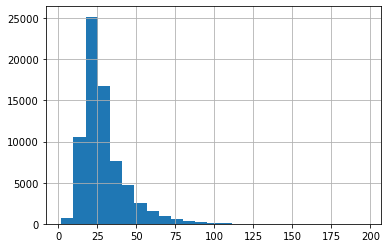

In [39]:
pd.Series(id_len).hist(bins=25)

In [45]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [46]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

<ipython-input-45-f6ebc5a4944a>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

  if labs != 'None':


(57707, 14427)

In [47]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

# 4. Loading Deep Learning Model

We used BERT for natural language processing based on deep learning model.

In [247]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']

- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some weights of BertForSequenceClassification were not initialized from the model checkpoint

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [248]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [249]:
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 5. Training

In [94]:
model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))
            
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
            
torch.save(model.state_dict(), 'nets/BERT.ckpt')

3200 / 57707

6400 / 57707

9600 / 57707

12800 / 57707

16000 / 57707

19200 / 57707

22400 / 57707

25600 / 57707

28800 / 57707

32000 / 57707

35200 / 57707

38400 / 57707

41600 / 57707

44800 / 57707

48000 / 57707

51200 / 57707

54400 / 57707

57600 / 57707

Epoch: 1, Loss: 0.1824

3200 / 57707

6400 / 57707

9600 / 57707

12800 / 57707

16000 / 57707

19200 / 57707

22400 / 57707

25600 / 57707

28800 / 57707

32000 / 57707

35200 / 57707

38400 / 57707

41600 / 57707

44800 / 57707

48000 / 57707

51200 / 57707

54400 / 57707

57600 / 57707

Epoch: 2, Loss: 0.1128

3200 / 57707

6400 / 57707

9600 / 57707

12800 / 57707

16000 / 57707

19200 / 57707

22400 / 57707

25600 / 57707

28800 / 57707

32000 / 57707

35200 / 57707

38400 / 57707

41600 / 57707

44800 / 57707

48000 / 57707

51200 / 57707

54400 / 57707

57600 / 57707

Epoch: 3, Loss: 0.0751

3200 / 57707

6400 / 57707

9600 / 57707

12800 / 57707

16000 / 57707

19200 / 57707

22400 / 57707

25600 / 57707

28800 / 57

# 6. Evaluation

In [96]:
model.eval()
model.load_state_dict(torch.load('nets/BERT.ckpt', map_location=device))

<All keys matched successfully>

In [108]:
score = 0
for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))

Accuracy: 0.9615




It showed 96.15% performance!

# 7. Run Demo

In [254]:
for i in range(5):
    idx = np.random.choice(range(len(news_data)))

    print('\033[1m'+news_data['title'][idx]+'\n')
    print('\033[0m'+news_data['text'][idx])

    label = news_data['label'][idx]
    text = news_data['title'][idx] + ' ' + news_data['refined_tfidf'][idx]

    input_id, attention_mask = tokenize_map([text])

    g_label = model(input_id.to(device), token_type_ids=None, attention_mask=attention_mask.to(device))[0]
    pred = torch.max(g_label, 1)[1][0].item()

    print('\n')
    print('Predict: {}'.format(class_names[pred]))
    print('GT: {}'.format(class_names[label]))
    print('---------------------------------------------------------------------------------------------\n')

STUNNER! FLORIDA TRUMP EVENT: Former Haitian Senate President Drops CLINTON BOMBSHELL Exposing Unbelievable Corruption [VIDEO]



Former Senate President of Haiti, Bernard Sansaricq, shocked a large crowd at a Trump campaign event in Little Haiti, FL. Sansaricq exposes all of the dirty dealings of the Clinton s in Haiti while he was still in office. Donald Trump to his credit, allowed him to speak his mind and expose to the world what kind of criminals are attempting to scratch and claw their way back into our White House.Sansaricq also claims he begged the Clinton Administration not to invade Haiti. His request was followed up with a visit by an anonymous messenger from the White House who encouraged him to  side  with the Clinton Administration and he would  be the richest man in Haiti. He also suggests that Hillary Clinton  disclose the audit of all money  related to the Haiti earthquake crisis, as he claims they scammed the poorest citizens of Haiti out of BILLIONS of dollars throu